## Resistant Cell Analysis

In [1]:
# Parameters
experiment_config_path = None
experiment_output_dir = None
force_view_calculation = False

concentration_fields, concentration_values_order, concentration_values_map = None, None, None
drug_fields, drug_values_order = None, None
array_fields, array_values_order = None, None

lambda_grid = '0,1,21'

In [2]:
# # Debugging
# experiment_config_path = '/lab/repos/celldom/config/experiment/exp-20180614-G3-K562-imatinib-poc-01.yaml'
# experiment_output_dir = '/lab/data/celldom/output/20181005-G3-full'
# concentration_fields = 'acq_cohort'
# concentration_values_order = 'Control,0.1uM,0.3uM,0.5uM'
# concentration_values_map = '0,.1,.3,.5'
# array_fields = 'acq_pump'
# lambda_grid = '0,1,21'
# drug_fields = None

In [3]:
import numpy as np
assert experiment_config_path, 'Must provide value for parameter `experiment_config_path`'
assert experiment_output_dir, 'Must provide value for parameter `experiment_output_dir`'
assert concentration_fields, 'Must provide value for parameter `concentration_fields`'

lambda_parts = lambda_grid.split(',')
assert len(lambda_parts) == 3, \
    'Must provide "lambda_grid" parameter as 3 comma separated values (start, stop, n); Value "{}" invalid'\
    .format(lambda_grid)
lambda_grid = np.linspace(*map(int, lambda_parts))

concentration_fields = concentration_fields.split(',') 
array_fields = array_fields.split(',') if array_fields else None
drug_fields = drug_fields.split(',') if drug_fields else None

concentration_values_order = concentration_values_order.split(',') if concentration_values_order else None
concentration_values_map = list(map(float, concentration_values_map.split(','))) if concentration_values_map else None
array_values_order = array_values_order.split(',') if array_values_order else None
drug_values_order = drug_values_order.split(',') if drug_values_order else None

if concentration_values_map:
    assert concentration_values_order, \
        'Order of concentration values must be supplied when providing conversion to numerical scale'
    assert len(concentration_values_order) == len(concentration_values_order), \
        'Length of concentration values order list ({}) must match that of numerical map ({})'\
        .format(concentration_values_order, concentration_values_map)

In [4]:
%run -m celldom.nb.logging
%matplotlib inline
import pandas as pd
import plotnine as pn
import matplotlib.pyplot as plt
from celldom.core.experiment import Experiment
from celldom.config import experiment_config
from celldom.execute import view

In [5]:
config = experiment_config.ExperimentConfig(experiment_config_path)
experiment = Experiment(config, data_dir=experiment_output_dir)
view.build_all(experiment, force=force_view_calculation)

In [6]:
df = experiment.get_view_store().get('apartment_summary')
df = view.remove_oob_apartments(experiment, df)
df.info()

2018-11-28 13:06:59,679:INFO:celldom.execute.view: Removing 43 rows of 15637 from data frame with apartment/street numbers outside of expected range (apartment range = [0, 57], street range = [0, 15])


<class 'pandas.core.frame.DataFrame'>
Int64Index: 15594 entries, 0 to 15636
Data columns (total 23 columns):
acq_pump                15594 non-null object
acq_color               15594 non-null object
acq_condition           15594 non-null object
acq_cohort              15594 non-null object
st_num                  15594 non-null object
apt_num                 15594 non-null object
acq_ids                 15594 non-null object
cell_counts             15594 non-null object
confluence              15594 non-null object
dates                   15594 non-null object
first_date              15594 non-null datetime64[ns]
first_hour              15594 non-null int64
growth_rate             9345 non-null float64
hours                   15594 non-null object
initial_condition       15594 non-null object
last_date               15594 non-null datetime64[ns]
last_hour               15594 non-null int64
max_count               15594 non-null float64
min_count               15594 non-null float64
n

In [7]:
count_field = 'tz_count_any_chamber'

def compute_percent_resistant(df):
    group_fields = (array_fields or []) + (drug_fields or []) + concentration_fields
    res = []
    for k, g in df[df['growth_rate'].notnull()].groupby(group_fields):
        for l in lambda_grid:
            res.append(dict(
                drug=g.iloc[0].filter(items=drug_fields or []).astype(str).str.cat(sep=':'),
                array=g.iloc[0].filter(items=array_fields or []).astype(str).str.cat(sep=':'),
                concentration=g.iloc[0].filter(items=concentration_fields).astype(str).str.cat(sep=':'),
                n_resistant=int(g[g['growth_rate'] >= l][count_field].sum()),
                n_total=int(g[count_field].sum()),
                threshold=l
            ))
    df = pd.DataFrame(res)
    df['pct_resistant'] = 100 * df['n_resistant'] / df['n_total']
    
    def order_factor(c, levels):
        if levels:
            diff = np.setdiff1d(df[c].unique(), levels)
            assert len(diff) == 0, \
                '{} value(s) "{}" not provided in ordered values passed in ("{}")'\
                .format(c, diff, levels)
        else:
            levels = sorted(df[c].unique())
        df[c] = pd.Categorical(df[c], ordered=True, categories=levels)

    order_factor('array', array_values_order)
    order_factor('drug', drug_values_order)
    order_factor('concentration', concentration_values_order)
    df = df.rename(columns={'concentration': 'conc_name'})
    if concentration_values_map:
        df['conc_value'] = df['conc_name'].map(dict(zip(concentration_values_order, concentration_values_map)))
        assert df['conc_value'].notnull().all()
    else:
        df['conc_value'] = df['conc_name'].cat.codes
    return df

df_res = compute_percent_resistant(df)
df_res.head()

,array,conc_name,drug,n_resistant,n_total,threshold,pct_resistant,conc_value
0,Elveflow,0.1uM,,528,721,0.00,73.231623,0.1
1,Elveflow,0.1uM,,446,721,0.05,61.858530,0.1
2,Elveflow,0.1uM,,367,721,0.10,50.901526,0.1
3,Elveflow,0.1uM,,302,721,0.15,41.886269,0.1
4,Elveflow,0.1uM,,255,721,0.20,35.367545,0.1


In [15]:
from sklearn.linear_model import LinearRegression
def compute_best_fit(df):
    def run_regression(g):
        # Remove any data points with no resistant cells as these are
        # invalid for exponential regression and log plots
        g = g[g['pct_resistant'] > 0]
        if len(g) == 0:
            return None
        
        # Regress log10 percent resistant cells on concentration
        x, y = g['conc_value'], g['pct_resistant']
        x, y = np.expand_dims(x.values, -1), y.values
        est = LinearRegression().fit(x, np.log10(y))
        
        # Attach predicted values and coefficients 
        gr = g.copy()
        gr['pct_resistant_pred'] = np.clip(10**est.predict(x), 0, 100)
        gr['coef_intercept'] = est.intercept_
        gr['coef_rate'] = est.coef_[0]
        return gr
    df = df.groupby(['array', 'drug', 'threshold'], group_keys=False).apply(run_regression)
    df['threshold_cat'] = pd.Categorical(
        df['threshold'].round(2).astype(str), ordered=True, 
        categories=df['threshold'].drop_duplicates().sort_values().round(2).astype(str)
    )
    return df

df_fit = compute_best_fit(df_res)
df_fit.head()

,array,conc_name,drug,n_resistant,n_total,threshold,pct_resistant,conc_value,pct_resistant_pred,coef_intercept,coef_rate,threshold_cat
0,Elveflow,0.1uM,,528,721,0.00,73.231623,0.1,73.231623,1.965920,-1.012216,0.0
21,Elveflow,Control,,441,477,0.00,92.452830,0.0,92.452830,1.965920,-1.012216,0.0
1,Elveflow,0.1uM,,446,721,0.05,61.858530,0.1,61.858530,1.962956,-1.715561,0.05
22,Elveflow,Control,,438,477,0.05,91.823899,0.0,91.823899,1.962956,-1.715561,0.05
2,Elveflow,0.1uM,,367,721,0.10,50.901526,0.1,50.901526,1.952925,-2.461946,0.1


### Resistant Cell Frequency by Growth Rate Threshold

This figure shows the percentage of resistant cells for a given growth rate threshold ($\lambda_{min}$) where this percentage is defined as the sum of time zero cell counts in apartments with a growth over $\lambda_{min}$ divided by the sum of time zero cell counts across all apartments with a valid growth rate (invalid growth rates register for apartments that have fewer than two usable data points or potentially, depending on the analysis configuration, no or more than one cell at time zero).

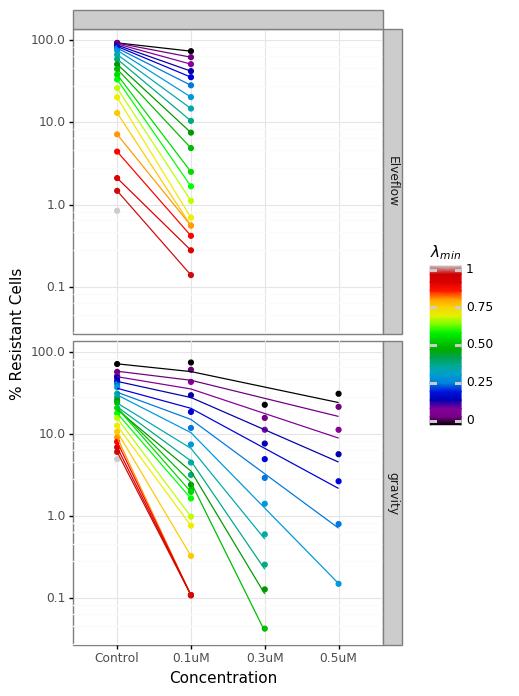

<ggplot: (8729693095365)>

In [9]:
n_array = df_fit['array'].nunique()
n_drug = df_fit['drug'].nunique()
(
    pn.ggplot(df_fit) +
    pn.geom_point(pn.aes(x='conc_name', y='pct_resistant', color='threshold')) +
    pn.geom_line(pn.aes(x='conc_name', y='pct_resistant_pred', group='threshold_cat', color='threshold')) +
    pn.facet_grid('array ~ drug') +
    pn.scale_color_cmap('nipy_spectral') +
    pn.scale_y_log10() + 
    pn.labs(x='Concentration', y='% Resistant Cells', color='$\lambda_{min}$', parse=True) +
    pn.theme_bw() + 
    pn.theme(figure_size=(n_drug * 4, n_array * 4))
)

### Resistant Cell Decay by Growth Rate Threshold

This figure is a different visualization of the data above where instead of showing resistant cell percentages for each concentration, concentration is ignored entirely and the slope of the "best fit line" above is shown as a function of the growth rate threshold $\lambda_{min}$.  This slope is denoted as $\beta_1$ and results from the regression equation:

$$p_i = 10^{\beta_0 + \beta_1 x_i}$$

where $p_i$ is the percentage of resistant cells and $x_i$ is the concentration index or value (depending on the arguments given).

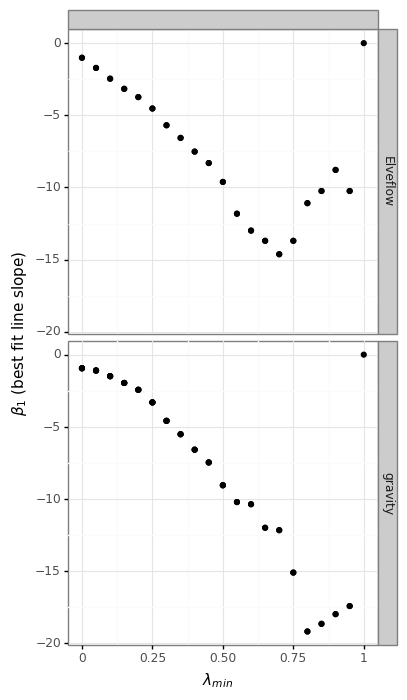

<ggplot: (-9223363307161785568)>

In [10]:
n_array = df_fit['array'].nunique()
n_drug = df_fit['drug'].nunique()
(
    pn.ggplot(df_fit) +
    pn.geom_point(pn.aes(x='threshold', y='coef_rate')) +
    pn.facet_grid('array ~ drug') +
    pn.labs(x='$\lambda_{min}$', y='$\\beta_1$ (best fit line slope)', parse=True) +
    pn.theme_bw() + 
    pn.theme(figure_size=(n_drug * 4, n_array * 4))
)